In [1]:
from neuron import h
import pandas as pd
import numpy as np
import json
import os
from typing import Optional, List, Tuple, Union

from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import params, paths

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
h.dt = params.DT
h.steps_per_ms = 1/h.dt

h.tstop = 400.

### Setup smiulation parameters

In [2]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json' # active dendrites
# filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_passive.json' # passive dendrites
with open(filepath) as f:
    biophys_param = json.load(f)

In [3]:
# Ra: basal, prox trunk, tuft, axon, passive basal
g_syn = 0 # multiple of g_leak
e_tot = (-72.0 * 1 + 0. * g_syn) / (1 + g_syn)
g_tot = (1 + g_syn) * 0.0000589
biophys = [e_tot, g_tot, 2.04, 0.0639, 0.693, 0.000261]  # 2.04, 0.0639, 0.693 (1.0), 0.000261
biophys_comm = {}

# interpret_params = False  # not using parameter interpreter
# geo_param = [135, 652, 163, 1.77, 1.26, .99] # 5 - 595 um
interpret_params = True  # using parameter interpreter
# geo_param = [1000, 1.]  # total length, radius scale
geo_param = [950., 0.142, 1., 0.59]  # total length 100-1200, prox prop 0.02-0.35, radius scale 0.4-1.5, dist/prox radius 0.4-0.8 [950., 0.142, 1., 0.59] 

loc_param = [0., 0., 0., 0., 1., 0.] # position (x,y,z,alpha,h,phi)

In [4]:
# h.tstop = 16.
ncell = 1
biophys_rep = np.tile(biophys,(ncell, 1)) 
# biophys_rep[:,5] = np.linspace(200, 300, ncell)
biophys = np.vstack((biophys_rep, biophys))
print(biophys)

[[-7.20e+01  5.89e-05  2.04e+00  6.39e-02  6.93e-01  2.61e-04]
 [-7.20e+01  5.89e-05  2.04e+00  6.39e-02  6.93e-01  2.61e-04]]


In [5]:
geo_param_rep = np.tile(geo_param,(ncell,1))
# geo_param_rep[:,6] = np.linspace(.1, .2, ncell)
# geo_param_rep[:,[2,3,4,6]] *= 1.0 # scale radius
geo_param = np.vstack((geo_param_rep, geo_param))
print(geo_param)

[[9.50e+02 1.42e-01 1.00e+00 5.90e-01]
 [9.50e+02 1.42e-01 1.00e+00 5.90e-01]]


In [6]:
gmax = [0.012]  # >=0.011, 0.0121
gmax = np.vstack((np.zeros((ncell, len(gmax))), gmax))
ncell += 1

In [7]:
biophys_entries = [
    ([5, 6], 'e_pas'), ([5, 6], 'g_pas'),
    (0, 'gNaTa_tbar_NaTa_t'), (1, 'gNaTa_tbar_NaTa_t'),
    (0, 'gSKv3_1bar_SKv3_1'), (1, 'gSKv3_1bar_SKv3_1'),
    (1, 'Ra'), (2, 'Ra'), (3, 'g_pas'),
    ([4, 5], 'gCa_HVAbar_Ca_HVA'), ([4, 5], 'gCa_LVAstbar_Ca_LVAst'),
    (3, 'gIhbar_Ih'), (4, 'gIhbar_Ih'), (5, 'gIhbar_Ih'), (6, 'gIhbar_Ih')
]
default_biophys = np.array([
    -72.0, 0.0000589,
    2.04, 0.0639,
    0.693, 0.000261,
    100, 100, 0.0000489,
    0.000555, 0.0187,
    0.00181, 0.00571, 0.00783, 0.01166 
])
# attr_kwargs = {'biophys_entries': biophys_entries, 'default_biophys': default_biophys}
attr_kwargs = {}

class Simulation_modified(Simulation):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
    def interpret_params(self):
        geo_param = np.full((self.ncell, 6), np.nan)
        L = self.geo_param[:, [0]]  # total length
        p1 = self.geo_param[:, [1]]  # proportion of prox
        trunk_L = self.geometry.loc[[4, 6, 7], 'L'].values  # length of each trunk section
        p23 = trunk_L[1:3] / (trunk_L[1] + trunk_L[2])  # fix ratio between mid and dist
        geo_param[:, [0]] = p1 * L
        geo_param[:, 1:3] = (1 - p1) * L * p23
        R = self.geo_param[:, [2]]  # radius scale of prox
        pR = self.geo_param[:, [3]]  # ratio of dist/prox radius
        geo_param[:, 3:6] = self.geometry.loc[4, 'R'] * R * pR ** np.array([0. , 0.5, 1.])
        self.geo_param = geo_param

In [8]:
sim = Simulation(
    cell_type = CellTypes.REDUCED_ORDER,
    ncell = ncell,
    geometry = geo_standard,
    electrodes = params.ELECTRODE_POSITION,
    loc_param = loc_param,
    geo_param = geo_param,
    biophys = biophys,
    full_biophys = biophys_param,
    biophys_comm = biophys_comm,
    gmax = gmax,
    stim_param = {'start': 2.},
    syn_sec = [0],
    interpret_params = interpret_params,
    min_distance = params.MIN_DISTANCE,
    spike_threshold = params.SPIKE_THRESHOLD,
    cell_kwargs = {'attr_kwargs': attr_kwargs}
)

print(sim.geo_param)

[[134.9        652.08       163.02         1.7694       1.35910193
    1.043946  ]
 [134.9        652.08       163.02         1.7694       1.35910193
    1.043946  ]]


#### Add current injection

In [9]:
for cell in sim.cells[:-1]:
    cell.add_injection(sec_index=0, pulse=True, record=True, amp=-0.010, delay=200.0, dur=200.0)

#### Record membrane potential

In [10]:
V_rec = Recorder(sim.cells[-1].segments)

### Simulation results

In [11]:
sim.run_neuron_sim()
# lfp = sim.get_lfp().T
t = sim.t()
v = sim.v('all')

In [12]:
nspk, tspk = sim.get_spike_number(-1)
tspk = tspk[tspk > sim.stim_param['start']]
nspk = tspk.size
print('Spike count: %d' % (nspk))

Spike count: 1


#### Membrane voltage

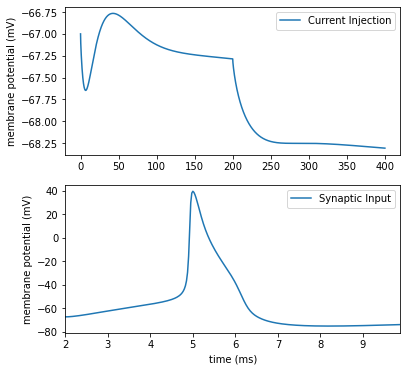

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(t, v[0], label='Current Injection')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t, v[-1], label='Synaptic Input')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.xlim([sim.stim.start, sim.stim.start + 20 if nspk == 0 else tspk[-1] + 5])
plt.show()

#### Calculate passive properties

In [14]:
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
%matplotlib inline

# plt.figure(figsize=(6,3*(ncell-1)))
# for i in range(ncell-1):
#     plt.subplot(ncell-1,1,i+1)
#     Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj,ax=plt.gca())
#     print((Vrest, Rin, Tau))

for i in range(ncell-1):
    Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj)
    print((Vrest, Rin, Tau))

# (-67.28648876896166, 102.19853962576195, 15.849999999985585)  # [950., 0.142, 1., 0.59] geo_param
# (-67.94989081468924, 122.86662601811145, 15.724999999985698)  # [950., 0.142, .7, 0.8]
# (-66.68920003388767, 66.73068344994846, 18.599999999983083)  # [1200., 0.35, 1.5, 0.8]
# (-68.18723921905612, 171.26541594565055, 14.574999999986744)  # [100., 0.02, .4, 0.4]

(-67.28648876896166, 102.19853962576195, 15.849999999985585)


#### Get segment coordinates for given cell and calculate electrotonic distance

In [15]:
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

cell = sim.cells[-1]
soma = cell.soma
section_list = cell.all
sec_type_swc = {sec['name']: sec['type'] for _, sec in geo_standard.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in section_list]
freq = 0 # Hz

seg_prop, Rin, Rin_pha = measure_segment_distance(soma, section_list, sec_type, freq)
print(Rin, Rin_pha) # Megohms, rad

115.79210569613811 0.0


In [16]:
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
%matplotlib inline

seg_coords = cell.seg_coords

tstart = sim.stim.start
dur = 12
t = sim.t()
t_idx = (t>=tstart) & (t<=tstart+dur)
im = sim.lfp[-1].calc_im()[:, t_idx]
# im_den = im / np.expand_dims(seg_prop['seg_area'], 1) # nA/um^2
im_den = im / np.diff(seg_prop['distance'], axis=1) # nA/um

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = im_den
varname = 'Transmembrane current density per unit length (nA/um)'
axes = ['x', 'y']
n_dist = 20
max_per_dist = 1
space = 1.
normalized_space = True
sort_by_dist = True
figsize = (12,9)
fontsize = 15
scalebar_size = 50

In [17]:
# _ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
#                                   distance_type='distance', n_dist=n_dist,
#                                   select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
#                                   space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
#                                   figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

In [18]:
# _ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
#                                   distance_type='elec_dist', n_dist=n_dist,
#                                   select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
#                                   space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
#                                   figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

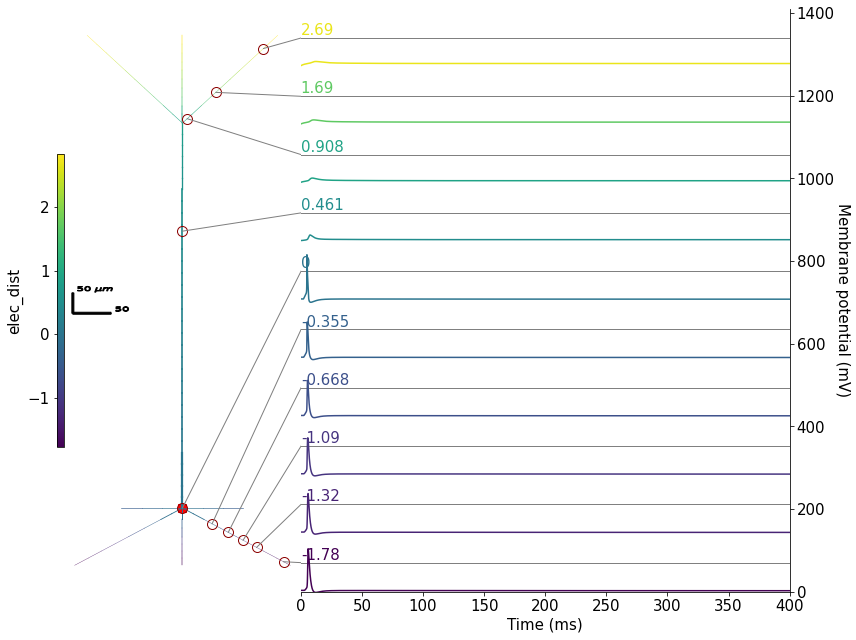

In [19]:
tstart = 0 # sim.stim.start
dur = h.tstop
t_idx = (t>=tstart) & (t<=tstart+dur)
Vm = V_rec.as_numpy()[:, t_idx]

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = Vm
varname = 'Membrane potential (mV)'
n_dist = 12
space = 2.
normalized_space = True
sort_by_dist = True

_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

#### Plot LFP

In [20]:
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp

loc_param = [0., 0., 80., 0., 1., np.pi*0/8]

if nspk == 0:
    raise ValueError('No spike.')
start_idx = int(np.ceil(sim.stim_param['start'] / h.dt)) # ignore signal before
end_idx = int(np.ceil(tspk[1] / h.dt)) if nspk > 1 else None
lfp = sim.lfp[-1].calc_ecp(move_cell=loc_param).T[slice(start_idx, end_idx),:]

output = process_lfp(lfp, y_window_size=params.Y_WINDOW_SIZE, ycoord=loc_param[1],
                     gauss_filt=True, calc_summ_stats=True, additional_stats=3)

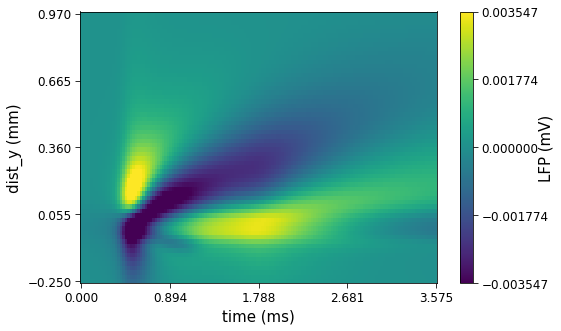

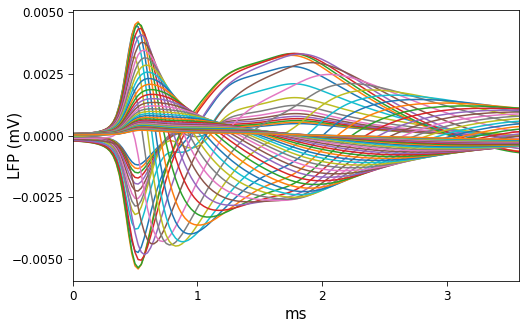

In [21]:
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
%matplotlib inline

ix = 1
fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5

d = output[1]
t = output[2]
coords = output[3]
x_dist = np.unique(coords[:, 0])
e_idx = coords[:, 0]==x_dist[ix]
ylim = [-250, 1100]
e_idx &= (coords[:, 1]>=ylim[0]) & (coords[:, 1]<=ylim[1])

plt.figure(figsize=(8,5))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=d[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())

plt.figure(figsize=(8,5))
_ = plot_lfp_traces(t, d[:, e_idx], #electrodes=coords[e_idx, :],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())

plt.show()

#### Check decay of LFP magnitude

In [22]:
import cell_inference.utils.feature_extractors.SummaryStats2D as ss
%matplotlib inline

dy = np.diff(params.ELECTRODE_GRID[1][:2])[0]
grid_shape = (ss.GRID_SHAPE[0], int(d.shape[1]/ss.GRID_SHAPE[0]))
t_t, t_p, troughs, peaks = ss.get_tr_pk(d)
y_troughs = ss.get_max_val_y(troughs, grid_shape)
y_peaks = ss.get_max_val_y(peaks, grid_shape)
lambda_troughs, pts_troughs, tr_max_idx = ss.get_decay(y_troughs)
lambda_peaks, pts_peaks, pk_max_idx = ss.get_decay(y_peaks)
tr_avg_mag = ss.volume_average(d, t_t, troughs, pts_troughs, tr_max_idx, grid_shape)
pk_avg_mag = ss.volume_average(d, t_p, peaks, pts_peaks, pk_max_idx, grid_shape)
# fit lines
l_troughs = ss.get_fit(y_troughs, pts_troughs)
l_peaks = ss.get_fit(y_peaks, pts_peaks)
for i in range(2):
    pts_troughs[i][2] *= dy
    pts_peaks[i][2] *= dy

np.set_printoptions(suppress=True)
print('Length constant (um) of troughs / peaks: \n  by lambda (left, right), by slope (left, right)')
print(dy * np.array([lambda_troughs, lambda_peaks]))
print('(w1, w2, y1) of two-line-segenmts (left, right) of troughs / peaks:')
print(pts_troughs)
print(pts_peaks)
print('average lfp magnitude in the neighbor volume (t, x, y) near the break point relative to the global maximum:')
print(ss.VOLUME_RANGE)
print('(left, right) of troughs / peaks:')
print(tr_avg_mag, pk_avg_mag )

Length constant (um) of troughs / peaks: 
  by lambda (left, right), by slope (left, right)
[[162.08223567 390.60278488 250.95929722 277.80748872]
 [200.05506831 225.73758098 242.8435255  275.02894816]]
(w1, w2, y1) of two-line-segenmts (left, right) of troughs / peaks:
[array([  2.36402401,   3.90501572, 383.16629676]), array([  1.04967935,   3.52762269, 410.00767569])]
[array([  3.28593015,   4.0355204 , 657.36698117]), array([  2.36868595,   3.56326127, 534.70143732])]
average lfp magnitude in the neighbor volume (t, x, y) near the break point relative to the global maximum:
[[[ -9   0 -14]
  [ 31   1   1]]

 [[ -9   0   0]
  [ 31   1  15]]]
(left, right) of troughs / peaks:
[-0.014661545815413308, -0.17364157044902698] [0.019191416011495956, 0.03959511142110924]


#### Apply log modulus transform to see small magnitude features

In [23]:
from cell_inference.utils.transform.data_transform import log_modulus

n_fold = 30
max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
n_fold = 2**max_logmod - 1
ref_mag = np.amax(np.abs(d)) / n_fold
print('Maximum magnitude is %d-fold reference magnitude %.3g mV.' % (n_fold, ref_mag))
lfp_logmod = log_modulus(d, ref_mag)

Maximum magnitude is 31-fold reference magnitude 0.00018 mV.


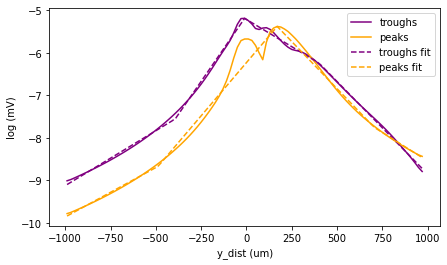

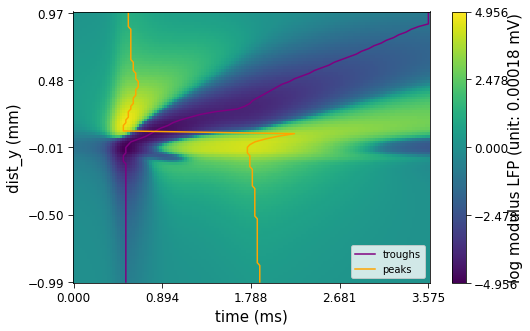

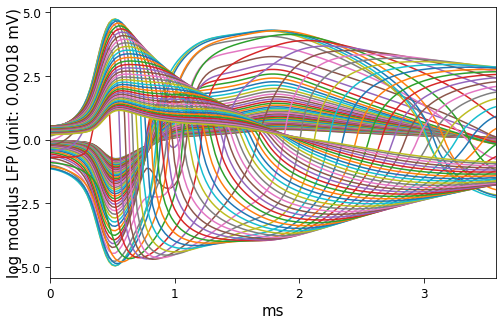

In [24]:
e_idx = coords[:, 0]==x_dist[ix]

plt.figure(figsize=(7,4))
plt.plot(coords[e_idx, 1], np.log(y_troughs), color='purple', label='troughs')
plt.plot(coords[e_idx, 1], np.log(y_peaks), color='orange', label='peaks')
plt.plot(coords[e_idx, 1], l_troughs, linestyle='--', color='purple', label='troughs fit')
plt.plot(coords[e_idx, 1], l_peaks, linestyle='--', color='orange', label='peaks fit')
plt.xlabel('y_dist (um)')
plt.ylabel('log (mV)')
plt.legend()

lfp_label = 'log modulus LFP (unit: %.3g mV)' % (ref_mag)

plt.figure(figsize=(8,5))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=lfp_logmod[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='max', colorbar_label=lfp_label, axes=plt.gca())
plt.plot(t[t_t[e_idx]], coords[e_idx, 1]/1000, color='purple', label='troughs')
plt.plot(t[t_p[e_idx]], coords[e_idx, 1]/1000, color='orange', label='peaks')
plt.legend()

plt.figure(figsize=(8,5))
_ = plot_lfp_traces(t, lfp_logmod[:, e_idx], # electrodes=coords[e_idx, :], vlim='max',
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel(lfp_label)

plt.show()

#### Plot morphology

<IPython.core.display.Javascript object>


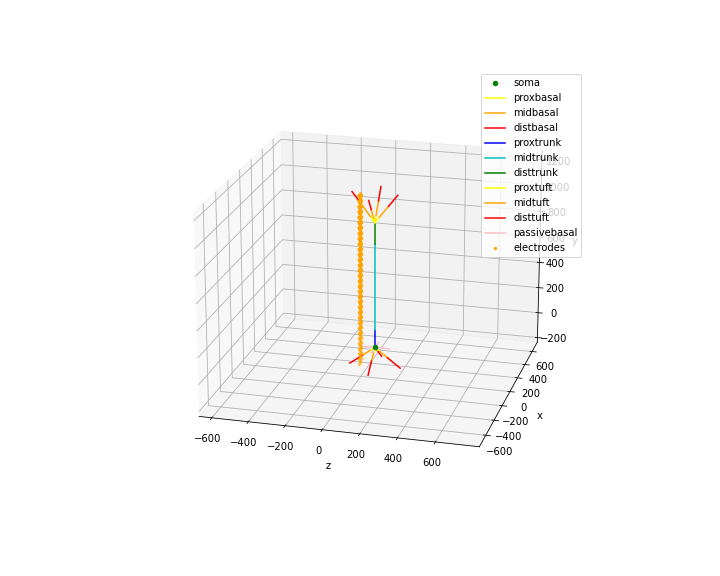

In [25]:
from cell_inference.utils.plotting.plot_morphology import plot_morphology
%matplotlib notebook

_ = plot_morphology(sim, ncell-1, electrodes=params.ELECTRODE_POSITION, move_cell=loc_param,
                    elev=20, azim=-75, figsize=(10,8),
                    clr = ['g',       #soma
                           'yellow',  #proxbasal
                           'orange',  #midbasal
                           'red',     #distbasal
                           'b',  #proxtrunk
                           'c',    #midtrunk
                           'g',   #disttrunk
                           'yellow',  #proxtuft
                           'orange',  #midtuft
                           'red',     #disttuft
                           'pink',       #axon
                           'purple']   #passivebasal
                   )